# Open-loop planning in CartPole with JaxPlan.

This rudimentary example illustrates how to set up an offline JaxPlan agent that first optimizes the problem and then evaluates.

First install and import the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [182]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
from IPython.display import Image

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxStraightLinePlan, JaxBackpropPlanner, JaxOfflineController, load_config_from_string

We will optimize the classical CartPole control problem. Please note that the environment state and action fluents should be vectorized tensors for JaxPlan, so we **must enable the ``vectorized`` option**:

In [183]:
env = pyRDDLGym.make('CartPole_Continuous_gym', '0', vectorized=True)

Now we will construct a straight-line plan as our policy, using the default parameters. This instantiates a trainable parameter vector for each action-fluent per decision time step:

In [184]:
planner = JaxBackpropPlanner(rddl=env.model, plan=JaxStraightLinePlan())

Let's instantiate an offline controller and begin optimization. Note that the controller is an instance of the pyRDDLGym ``BasePolicy``, so it supports interaction with pyRDDLGym out of the box:

In [185]:
agent = JaxOfflineController(planner, print_summary=False, train_seconds=10)
agent.evaluate(env, episodes=1)

   1510 it /      43.080311 train /      60.200001 test /      70.300003 best / 0 status: : 1510it [00:10, 145.77it/s] 


{'mean': 76.0, 'median': 76.0, 'min': 76.0, 'max': 76.0, 'std': 0.0}

We can do better! Since JaxPlan can be sensitive to hyper-parameter choices, Let's repeat the previous exercise but with tweaked hyper-parameters. Specifically, let's make the model relaxations much tighter, decrease the learning rate, clip the gradient for stability, and remove mini-batching since this environment is deterministic. This is much easier to provide in a configuration file as follows:

In [192]:
config = """
[Model]
logic_kwargs={'weight': 1000.0}
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.001}
batch_size_train=1
batch_size_test=1
clip_grad=0.5
[Training]
"""
planner_args, _, train_args = load_config_from_string(config)

In [193]:
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False,  train_seconds=10, **train_args)
agent.evaluate(env, episodes=1)

   3648 it /     200.000000 train /     200.000000 test /     200.000000 best / 1 status: : 3648it [00:11, 325.23it/s] 


{'mean': 200.0, 'median': 200.0, 'min': 200.0, 'max': 200.0, 'std': 0.0}

Let's visualize our trained agent's behavior:

200


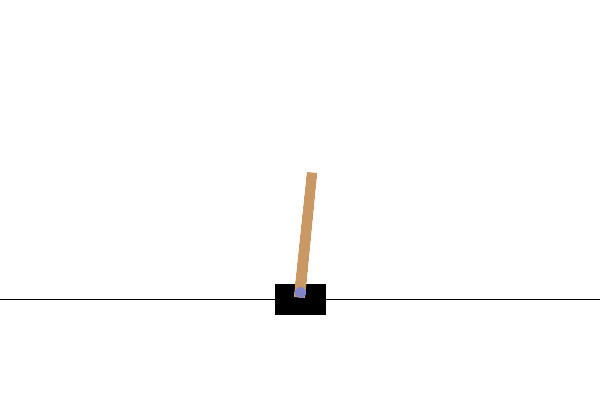

In [188]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "cartpole", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)
agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/cartpole_0.gif') 